In [32]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

In [33]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [34]:
# Reading the dataset and creating a dataframe

dataset = pd.read_csv("HourlyGIData.csv", skiprows=8, skipfooter=9)
df = pd.DataFrame(dataset)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_29628\4039231411.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv("HourlyGIData.csv", skiprows=8, skipfooter=9)


# Explanations of the Variables
<b>G(i):</b> Global irradiance on the inclined plane (plane of the array) (W/m2)<br>
<b>H_sun:</b> Sun height (degree)<br>
<b>T2m:</b> 2-m air temperature (degree Celsius)<br>
<b>WS10m:</b> 10-m total wind speed (m/s)<br>
<b>Int:</b> 1 means solar radiation values are reconstructed<br>
<br>
Since the "Int" value is 0 on every row, it can be dropped.

In [35]:
df = df.drop(['Int'], axis=1)

df

,time,G(i),H_sun,T2m,WS10m
0,20050101:0010,0.0,0.0,7.52,2.62
1,20050101:0110,0.0,0.0,7.27,2.69
2,20050101:0210,0.0,0.0,7.01,2.55
3,20050101:0310,0.0,0.0,6.80,2.28
4,20050101:0410,0.0,0.0,6.58,2.14
...,...,...,...,...,...
8755,20051231:1910,0.0,0.0,4.22,4.21
8756,20051231:2010,0.0,0.0,4.01,4.21
8757,20051231:2110,0.0,0.0,3.83,4.34
8758,20051231:2210,0.0,0.0,3.72,4.41


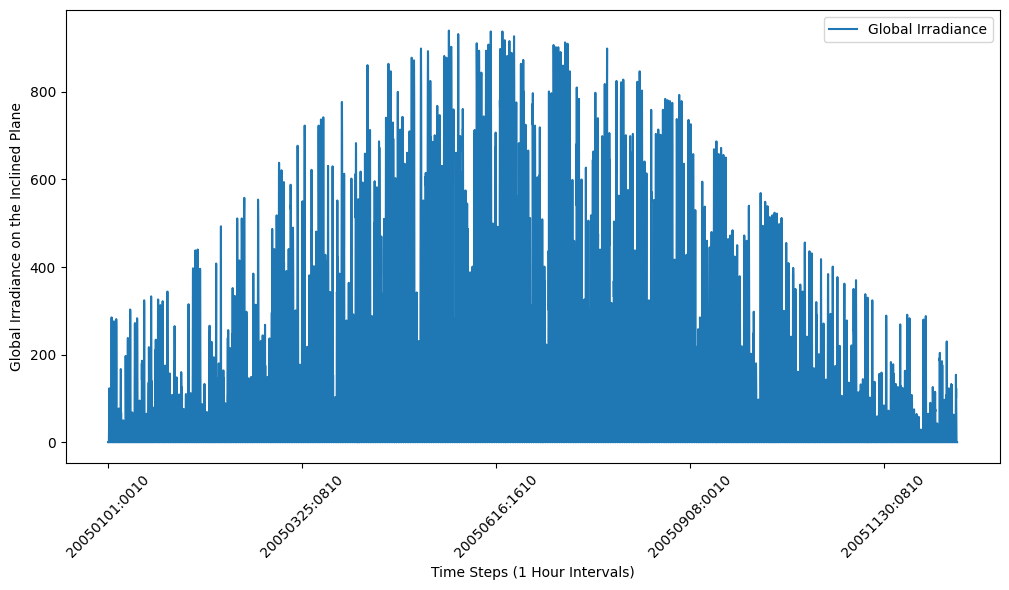

In [36]:
# Line plot of global horizontal irradiance with respect to time

# Plot the line chart
ax = df.plot(x='time', y='G(i)', label='Global Irradiance', kind='line', figsize=(10, 6))

# Adjust x-axis ticks to display fewer labels
xtick_positions = ax.get_xticks()  # Get the default tick positions

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Irradiance on the Inclined Plane')
plt.show()

While it is not necessary since the data is already sequential, and the columns will be dropped while the LSTM model is being trained, the time data will be separated into four columns: 'year', 'month', 'day', and 'hour'.

# Data Preparation

In [37]:
# Initializing empty lists
year = []
month = []
day = []
hour = []

# Separating the 'time' string element into desired data
for i in range(len(df['time'])):

    temp_str = ''
    temp_str = temp_str + df['time'][i][0:4]
    year.append(temp_str)

    temp_str = ''
    temp_str = temp_str + df['time'][i][4:6]
    month.append(temp_str)

    temp_str = ''
    temp_str = temp_str + df['time'][i][6:8]
    day.append(temp_str)

    temp_str = ''
    temp_str = temp_str + df['time'][i][9:]
    hour.append(temp_str)

print(hour)

['0010', '0110', '0210', '0310', '0410', '0510', '0610', '0710', '0810', '0910', '1010', '1110', '1210', '1310', '1410', '1510', '1610', '1710', '1810', '1910', '2010', '2110', '2210', '2310', '0010', '0110', '0210', '0310', '0410', '0510', '0610', '0710', '0810', '0910', '1010', '1110', '1210', '1310', '1410', '1510', '1610', '1710', '1810', '1910', '2010', '2110', '2210', '2310', '0010', '0110', '0210', '0310', '0410', '0510', '0610', '0710', '0810', '0910', '1010', '1110', '1210', '1310', '1410', '1510', '1610', '1710', '1810', '1910', '2010', '2110', '2210', '2310', '0010', '0110', '0210', '0310', '0410', '0510', '0610', '0710', '0810', '0910', '1010', '1110', '1210', '1310', '1410', '1510', '1610', '1710', '1810', '1910', '2010', '2110', '2210', '2310', '0010', '0110', '0210', '0310', '0410', '0510', '0610', '0710', '0810', '0910', '1010', '1110', '1210', '1310', '1410', '1510', '1610', '1710', '1810', '1910', '2010', '2110', '2210', '2310', '0010', '0110', '0210', '0310', '0410',

In [38]:
# Appending the lists into the dataframe
df['year'] = year
df['month'] = month
df['day'] = day
df['hour'] = hour

In [39]:
df

,time,G(i),H_sun,T2m,WS10m,year,month,day,hour
0,20050101:0010,0.0,0.0,7.52,2.62,2005,01,01,0010
1,20050101:0110,0.0,0.0,7.27,2.69,2005,01,01,0110
2,20050101:0210,0.0,0.0,7.01,2.55,2005,01,01,0210
3,20050101:0310,0.0,0.0,6.80,2.28,2005,01,01,0310
4,20050101:0410,0.0,0.0,6.58,2.14,2005,01,01,0410
...,...,...,...,...,...,...,...,...,...
8755,20051231:1910,0.0,0.0,4.22,4.21,2005,12,31,1910
8756,20051231:2010,0.0,0.0,4.01,4.21,2005,12,31,2010
8757,20051231:2110,0.0,0.0,3.83,4.34,2005,12,31,2110
8758,20051231:2210,0.0,0.0,3.72,4.41,2005,12,31,2210


In [40]:
# Creating our desired dataframe
df = df.drop(['time'], axis=1)

new_cols = ['year', 'month', 'day', 'hour', 'G(i)', 'H_sun', 'T2m', 'WS10m']

df_copy = df # Backup in case the dataframe gets corrupted

df = df.reindex(columns=new_cols)

df

,year,month,day,hour,G(i),H_sun,T2m,WS10m
0,2005,01,01,0010,0.0,0.0,7.52,2.62
1,2005,01,01,0110,0.0,0.0,7.27,2.69
2,2005,01,01,0210,0.0,0.0,7.01,2.55
3,2005,01,01,0310,0.0,0.0,6.80,2.28
4,2005,01,01,0410,0.0,0.0,6.58,2.14
...,...,...,...,...,...,...,...,...
8755,2005,12,31,1910,0.0,0.0,4.22,4.21
8756,2005,12,31,2010,0.0,0.0,4.01,4.21
8757,2005,12,31,2110,0.0,0.0,3.83,4.34
8758,2005,12,31,2210,0.0,0.0,3.72,4.41


To train the LSTM model, these new columns are unnecessary, so they will be dropped from the main dataframe. However, a backup dataframe will be created with this if we ever need it.

In [41]:
df_timedata = df

df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

df

,G(i),H_sun,T2m,WS10m
0,0.0,0.0,7.52,2.62
1,0.0,0.0,7.27,2.69
2,0.0,0.0,7.01,2.55
3,0.0,0.0,6.80,2.28
4,0.0,0.0,6.58,2.14
...,...,...,...,...
8755,0.0,0.0,4.22,4.21
8756,0.0,0.0,4.01,4.21
8757,0.0,0.0,3.83,4.34
8758,0.0,0.0,3.72,4.41


# Training the Model
First, the LSTM model will be trained with the data separated as 80% training data and 20% testing data. <br>
This part will train the model on existing data, so the model will predict the next values while having access to previous data. <br>
For forecasting, see the next sections.

In [42]:
df_GI = df.iloc[:, [0]]

df_GI

,G(i)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8755,0.0
8756,0.0
8757,0.0
8758,0.0


In [43]:
# Preparing dataset for LSTM training

df_lstm = df_GI.values
df_lstm = df_lstm.astype('float32')

In [44]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [45]:
# Split into train and test sets

train_size = int(len(df_lstm) * 0.80) # Splitting into 80% and 20%
test_size = len(df_lstm) - train_size
train, test = df_lstm[0:train_size,:], df_lstm[train_size:len(df_lstm),:]
print(len(train), len(test))

7008 1752


In [46]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [47]:
# Reshape into X=t and Y=t+1

look_back = 10 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
np.shape(trainX)

(6997, 1, 10)

In [50]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6997/6997 - 27s - 4ms/step - loss: 0.0132
Epoch 2/100
6997/6997 - 17s - 2ms/step - loss: 0.0079
Epoch 3/100
6997/6997 - 17s - 2ms/step - loss: 0.0078
Epoch 4/100
6997/6997 - 16s - 2ms/step - loss: 0.0077
Epoch 5/100
6997/6997 - 15s - 2ms/step - loss: 0.0076
Epoch 6/100
6997/6997 - 16s - 2ms/step - loss: 0.0076
Epoch 7/100
6997/6997 - 17s - 2ms/step - loss: 0.0075
Epoch 8/100
6997/6997 - 17s - 2ms/step - loss: 0.0075
Epoch 9/100
6997/6997 - 15s - 2ms/step - loss: 0.0074
Epoch 10/100
6997/6997 - 16s - 2ms/step - loss: 0.0074
Epoch 11/100
6997/6997 - 16s - 2ms/step - loss: 0.0073
Epoch 12/100
6997/6997 - 16s - 2ms/step - loss: 0.0073
Epoch 13/100
6997/6997 - 15s - 2ms/step - loss: 0.0073
Epoch 14/100
6997/6997 - 17s - 2ms/step - loss: 0.0072
Epoch 15/100
6997/6997 - 16s - 2ms/step - loss: 0.0072
Epoch 16/100
6997/6997 - 16s - 2ms/step - loss: 0.0072
Epoch 17/100
6997/6997 - 17s - 2ms/step - loss: 0.0072
Epoch 18/100
6997/6997 - 17s - 2ms/step - loss: 0.0072
Epoch 19/100
6997/6

In [51]:
# Make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 76.96 RMSE
Test Score: 50.92 RMSE


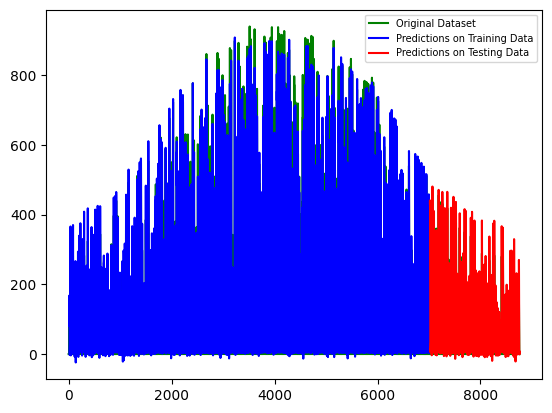

In [52]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_lstm)-1, :] = testPredict

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')
plt.legend(fontsize=7)
plt.show()

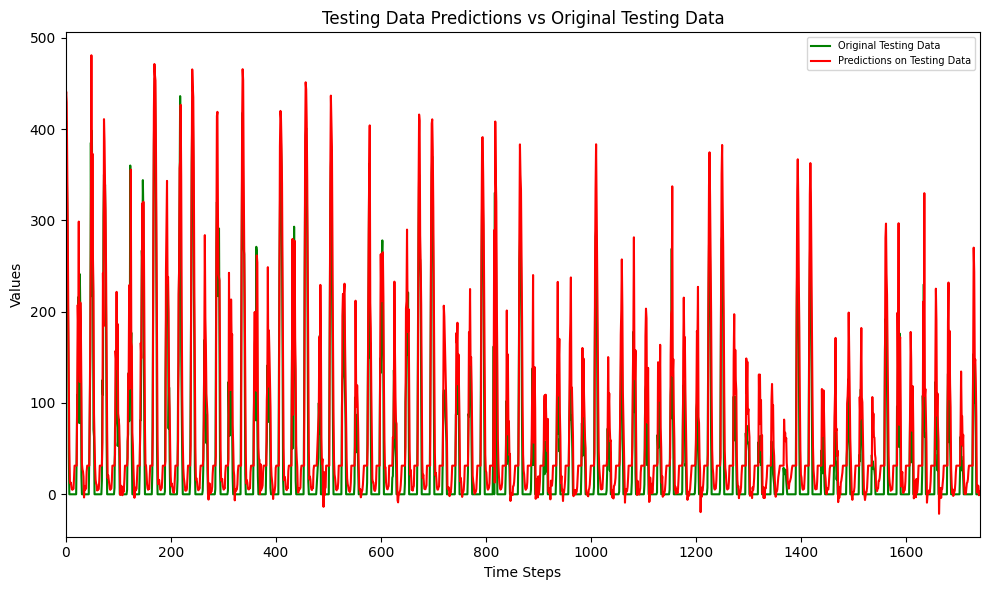

In [53]:
# Looking at the testing data closer

# Define the start and end of the testing data
test_start = len(trainPredict) + (look_back * 2) + 1
test_end = len(df_lstm) - 1

# Extract the original testing data
original_test_data = scaler.inverse_transform(df_lstm)[test_start:test_end]

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[test_start:test_end, :] = testPredict

# Plot only the testing predictions and original testing data
plt.figure(figsize=(10, 6))  # Adjust figure size for clarity
plt.plot(original_test_data, 'g', label='Original Testing Data')  # Original test data
plt.plot(testPredict, 'r', label='Predictions on Testing Data')   # Test predictions

# Zoom in on the testing portion
plt.xlim(0, len(original_test_data))  # Limit x-axis to the testing range
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("Testing Data Predictions vs Original Testing Data")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Predicting the Global Irradiance of the first 72 hours with look_back = 10')

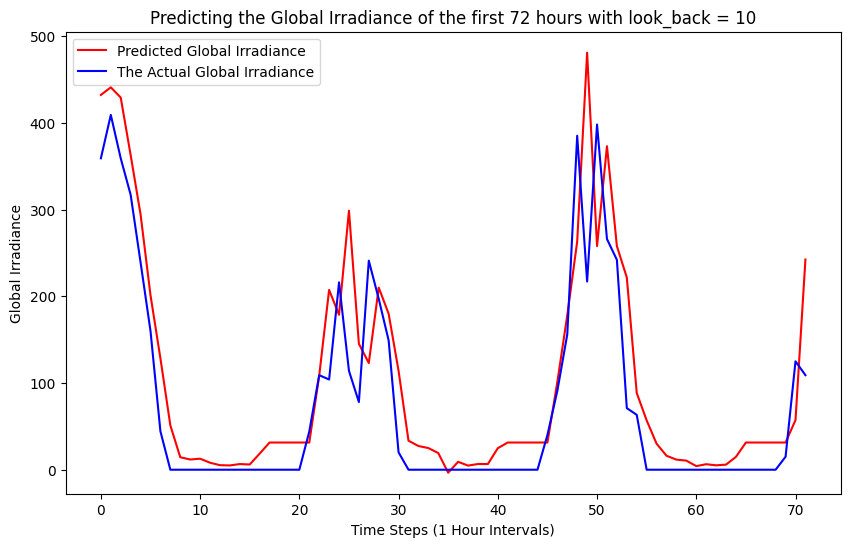

In [54]:
# Plotting the first 72 hours of predictions

plt.figure(figsize=(10, 6))
plt.plot(testPredict[:72], 'r-', label='Predicted Global Irradiance')
plt.plot(original_test_data[:72], 'b', label='The Actual Global Irradiance')
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Irradiance')
plt.legend()
plt.title("Predicting the Global Irradiance of the first 72 hours with look_back = " + str(look_back))

It can be seen that the model works optimally in detecting trends and fluctuations when it is given a correct set of data, but this test does not prove anything about the model's forecasting capabilities. <br>
In the next section, the model's forecasting is tested.

# Forecasting

In [23]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
df_to_forecast = df_GI.iloc[-1752:]
df_to_forecast = df_to_forecast.reset_index(drop=True)
df_to_train = df_GI.iloc[:-1752]

df_lstm = df_to_train.values
df_lstm = df_lstm.astype('float32')

raw_seq = df_lstm

# split into samples
X, y = split_sequence(raw_seq, look_back)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [29.]] [60.]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [29.]
 [60.]] [63.]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [29.]
 [60.]
 [63.]] [81.]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [29.]
 [60.]
 [63.]
 [81.]] [123.]
[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 29.]
 [ 60.]
 [ 63.]
 [ 81.]
 [123.]] [74.]
[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 29.]
 [ 60.]
 [ 63.]
 [ 81.]
 [123.]
 [ 74.]] [41.37]
[[  0.  ]
 [  0.  ]
 [  0.  ]
 [ 29.  ]
 [ 60.  ]
 [ 63.  ]
 [ 81.  ]
 [123.  ]
 [ 74.  ]
 [ 41.37]] [0.]
[[  0.  ]
 [  0.  ]
 [ 29.  ]
 [ 60.  ]
 [ 63.  ]
 [ 81.  ]
 [123.  ]
 [ 74.  ]
 [ 41.37]
 [  0.  ]] [0.]
[[  0.  ]
 [ 29.  ]
 [ 60.  ]
 [ 63.  ]
 [ 81.  ]
 [123.  ]
 [ 74.  ]
 [ 41.37]
 [  0.  ]
 [  0.  ]] [0.]
[[ 29.  ]
 [ 60.  ]
 [ 63.  ]
 [ 81.  ]
 [123.  ]
 [ 74.  ]
 [ 41.37]
 [  0.  ]
 [  0.  ]
 [  0.  ]] [0.]
[[ 60.  ]
 [ 63.  ]
 [ 81.  ]
 [123.  ]
 [ 74.  ]
 [ 41.37]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 

In [24]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=300, verbose=2)

Epoch 1/300


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 - 3s - 13ms/step - loss: 24624.6680
Epoch 2/300
219/219 - 2s - 9ms/step - loss: 16325.1064
Epoch 3/300
219/219 - 2s - 11ms/step - loss: 8026.5435
Epoch 4/300
219/219 - 2s - 10ms/step - loss: 7448.0645
Epoch 5/300
219/219 - 2s - 11ms/step - loss: 7189.9727
Epoch 6/300
219/219 - 2s - 11ms/step - loss: 7271.3633
Epoch 7/300
219/219 - 2s - 11ms/step - loss: 6934.6772
Epoch 8/300
219/219 - 2s - 11ms/step - loss: 6799.2988
Epoch 9/300
219/219 - 2s - 11ms/step - loss: 7044.3682
Epoch 10/300
219/219 - 2s - 10ms/step - loss: 11810.9873
Epoch 11/300
219/219 - 2s - 8ms/step - loss: 9141.6836
Epoch 12/300
219/219 - 2s - 10ms/step - loss: 16875.9121
Epoch 13/300
219/219 - 2s - 11ms/step - loss: 8167.1973
Epoch 14/300
219/219 - 2s - 11ms/step - loss: 8208.3740
Epoch 15/300
219/219 - 2s - 11ms/step - loss: 7274.7803
Epoch 16/300
219/219 - 2s - 11ms/step - loss: 7114.9517
Epoch 17/300
219/219 - 2s - 11ms/step - loss: 7216.3516
Epoch 18/300
219/219 - 2s - 11ms/step - loss: 7272.3247
Epoch 19/30

In [25]:
# Prediction demonstration
x_input = array(df_to_forecast[0:look_back])
x_input = x_input.reshape((1, look_back, n_features))
yhat = model.predict(x_input, verbose=0)

print(x_input)
print(yhat)

[[[  0.  ]
  [  0.  ]
  [  0.  ]
  [  0.  ]
  [  0.  ]
  [  0.  ]
  [  0.  ]
  [ 37.  ]
  [143.  ]
  [294.01]]]
[[422.57135]]


In [26]:
# Getting the forecasting predictions

prediction_list = [] # Initialize empty array to store predictions

# Extracting float values from the nested structure
to_forecast_values = [item[0] for item in df_lstm[-look_back:]]

# Feeding the model the initial data
for i in range(look_back):

    prediction_list.append(to_forecast_values[i])

for i in range(1752):

    x_input = array(prediction_list[i:i+look_back])
    x_input = x_input.reshape((1, look_back, n_features))
    yhat = model.predict(x_input, verbose=0)

    prediction_list.append(yhat[0][0])

In [27]:
filtered_float_values = prediction_list[look_back:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(filtered_float_values, df_to_forecast))

# Print RMSE
print("RMSE:", rmse)

RMSE: 183.94696311417925


Text(0.5, 1.0, 'Forecasting the Global Irradiance with look_back = 10')

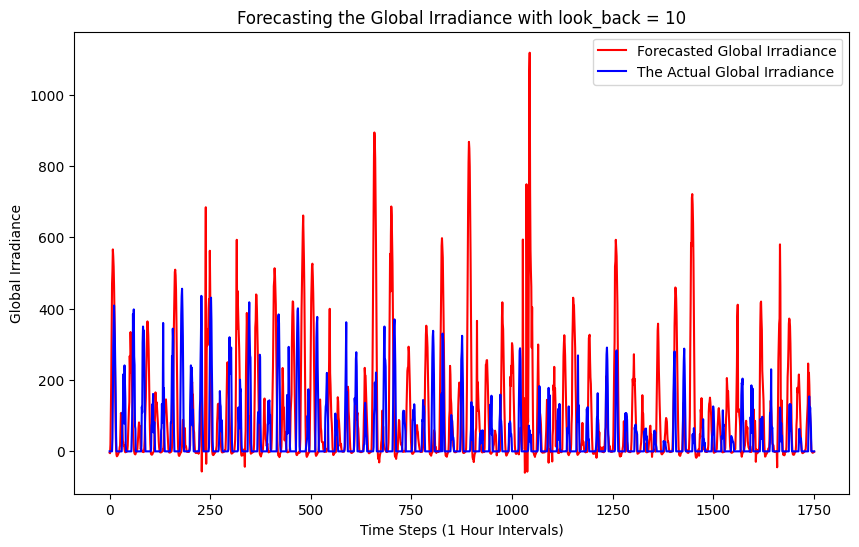

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_float_values, 'r-', label='Forecasted Global Irradiance')
plt.plot(df_to_forecast, 'b', label='The Actual Global Irradiance')
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Irradiance')
plt.legend()
plt.title("Forecasting the Global Irradiance with look_back = " + str(look_back))

Text(0.5, 1.0, 'Forecasting the Global Irradiance of the first 24 hours with look_back = 10')

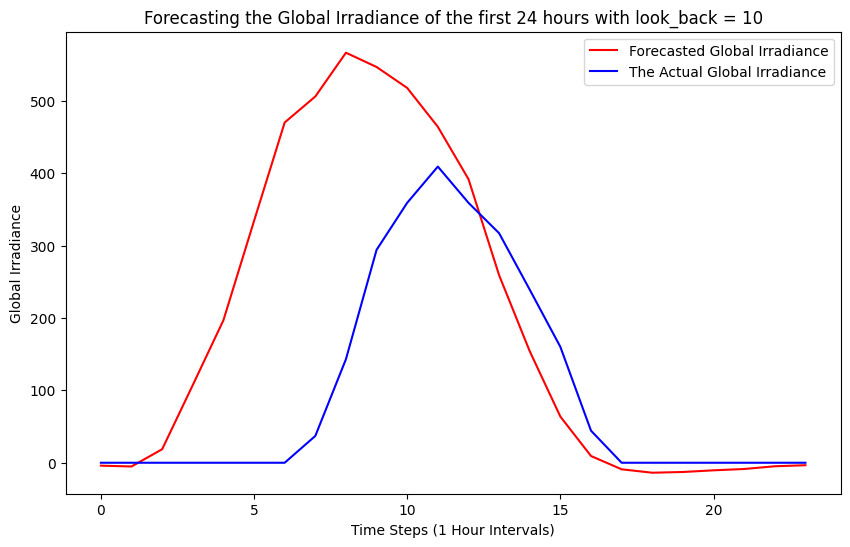

In [29]:
# Plotting the first 24 hours of predictions

plt.figure(figsize=(10, 6))
plt.plot(filtered_float_values[:24], 'r-', label='Forecasted Global Irradiance')
plt.plot(df_to_forecast[:24], 'b', label='The Actual Global Irradiance')
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Irradiance')
plt.legend()
plt.title("Forecasting the Global Irradiance of the first 24 hours with look_back = " + str(look_back))

With parameter tuning and optimization, the model can forecast the trends of the data accurately.

# Training the Model With Multiple Features
So far, both the predictions and forecasting were made with only one feature being regarded. <br>
Under this section, every feature of the dataset will be utilized to train the dataset.

In [23]:
df_copy = df
df_copy

,G(i),H_sun,T2m,WS10m
0,0.0,0.0,7.52,2.62
1,0.0,0.0,7.27,2.69
2,0.0,0.0,7.01,2.55
3,0.0,0.0,6.80,2.28
4,0.0,0.0,6.58,2.14
...,...,...,...,...
8755,0.0,0.0,4.22,4.21
8756,0.0,0.0,4.01,4.21
8757,0.0,0.0,3.83,4.34
8758,0.0,0.0,3.72,4.41


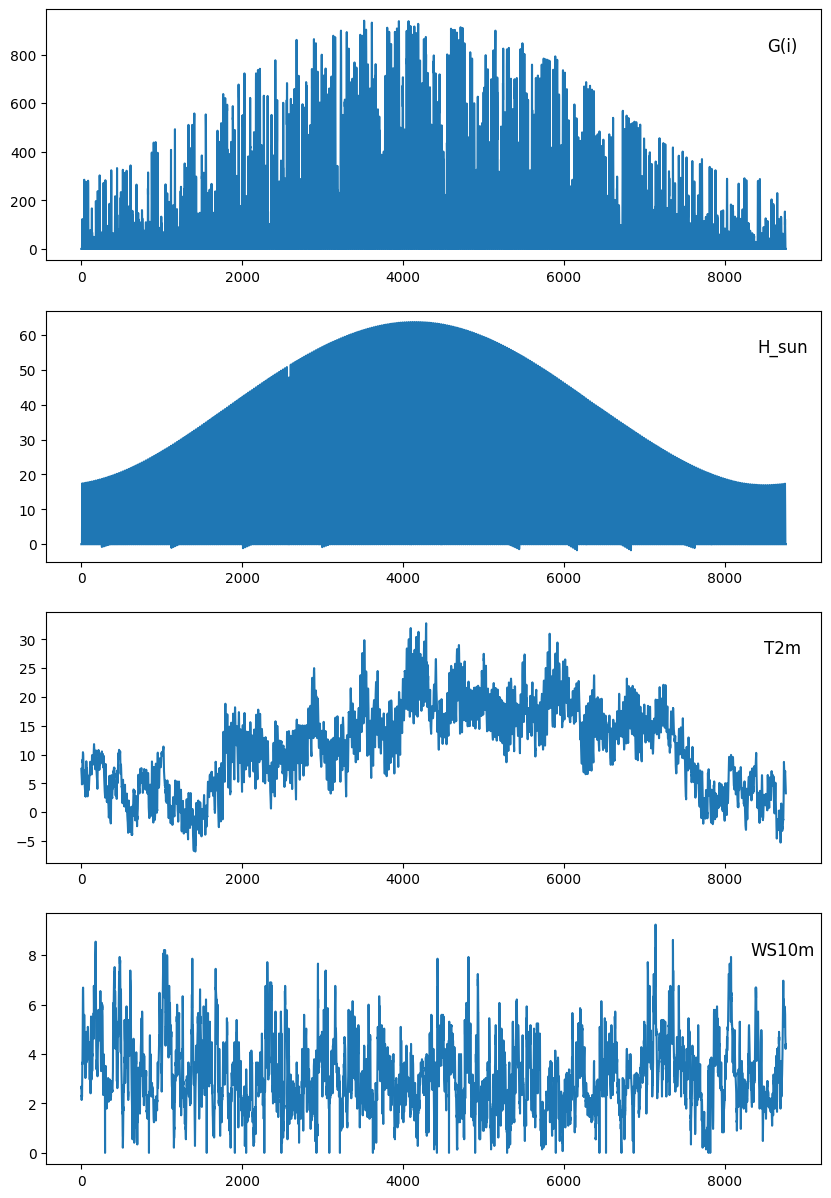

In [24]:
# Creating separate subplots for each series
values = df_copy.values

# Specify columns to plot
groups = [0, 1, 2, 3]
i = 1

# Plot each column
plt.figure(figsize=(10, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_copy.columns[group], y=0.8, x=0.95)
	i += 1
plt.show()

In [25]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	# Input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
	# Forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# Put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	# Drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [26]:
# Load dataset
values = df_copy.values

# Integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the number of time steps and features
look_back = 2
n_features = 4

# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)   var2(t)   var3(t)  \
1        0.0   0.026436   0.362421   0.283550      0.0  0.026436  0.356116   
2        0.0   0.026436   0.356116   0.291126      0.0  0.026436  0.349559   
3        0.0   0.026436   0.349559   0.275974      0.0  0.026436  0.344262   
4        0.0   0.026436   0.344262   0.246753      0.0  0.026436  0.338714   
5        0.0   0.026436   0.338714   0.231602      0.0  0.026436  0.327112   

    var4(t)  
1  0.291126  
2  0.275974  
3  0.246753  
4  0.231602  
5  0.239177  


Since we still want to only predict the hourly global horizontal irradiance, the other columns will be dropped to not get their predicted outputs. <br>
If a prediction with multiple time steps is to be reached, dropping columns is not needed.

In [27]:
# Drop columns we don't want to predict
# reframed.drop(reframed.columns[[5, 6, 7]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)   var2(t)   var3(t)  \
1        0.0   0.026436   0.362421   0.283550      0.0  0.026436  0.356116   
2        0.0   0.026436   0.356116   0.291126      0.0  0.026436  0.349559   
3        0.0   0.026436   0.349559   0.275974      0.0  0.026436  0.344262   
4        0.0   0.026436   0.344262   0.246753      0.0  0.026436  0.338714   
5        0.0   0.026436   0.338714   0.231602      0.0  0.026436  0.327112   

    var4(t)  
1  0.291126  
2  0.275974  
3  0.246753  
4  0.231602  
5  0.239177  


In [28]:
np.shape(reframed)

(8759, 8)

In [29]:
# Split into train and test sets using iloc
train_size = int(len(reframed) * 0.80)
test_size = len(reframed) - train_size

train, test = reframed.iloc[0:train_size, :], reframed.iloc[train_size:len(reframed), :]
print(len(train), len(test))

# Split into input and outputs
n_obs = look_back * n_features
train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -n_features].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -n_features].values
print(train_X.shape, len(train_X), train_y.shape)

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], look_back, n_features))
test_X = test_X.reshape((test_X.shape[0], look_back, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

7007 1752
(7007, 8) 7007 (7007,)
(7007, 2, 4) (7007,) (1752, 2, 4) (1752,)


Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 - 3s - 30ms/step - loss: 0.0743 - val_loss: 0.0222
Epoch 2/100
98/98 - 1s - 9ms/step - loss: 0.0406 - val_loss: 0.0189
Epoch 3/100
98/98 - 1s - 9ms/step - loss: 0.0324 - val_loss: 0.0174
Epoch 4/100
98/98 - 1s - 9ms/step - loss: 0.0234 - val_loss: 0.0114
Epoch 5/100
98/98 - 1s - 9ms/step - loss: 0.0121 - val_loss: 0.0061
Epoch 6/100
98/98 - 1s - 9ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 7/100
98/98 - 1s - 9ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 8/100
98/98 - 1s - 9ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 9/100
98/98 - 1s - 9ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 10/100
98/98 - 1s - 9ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/100
98/98 - 1s - 9ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 12/100
98/98 - 1s - 9ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 13/100
98/98 - 1s - 9ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 14/100
98/98 - 1s - 9ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 15/100
98/98 - 1s - 8ms/step - loss: 0.0029 - va

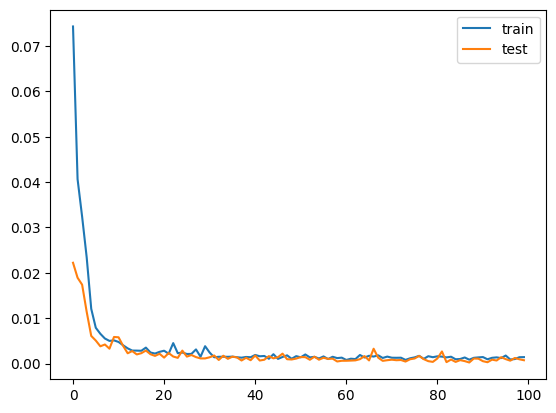

In [30]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
# Make a prediction
testPredict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]*look_back))
trainPredict = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]*look_back))

# Invert scaling for forecast
inv_testPredict = np.concatenate((testPredict, test_X[:, -3:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
inv_testPredict = inv_testPredict[:,0]

inv_trainPredict = np.concatenate((trainPredict, train_X[:, -3:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_trainPredict = inv_trainPredict[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

train_y = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y, train_X[:, -3:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_testPredict))
print('Test RMSE: %.3f' % rmse)
rmse = np.sqrt(mean_squared_error(inv_y_train, inv_trainPredict))
print('Train RMSE: %.3f' % rmse)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 1.284
Train RMSE: 3.403


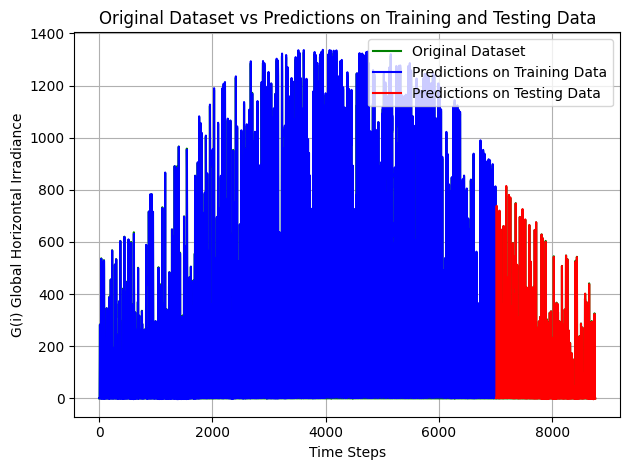

In [32]:
# Create arrays for plotting
trainPredictPlot = np.empty_like(df_copy['G(i)'].values)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:look_back + len(inv_trainPredict)] = inv_trainPredict

testPredictPlot = np.empty_like(df_copy['G(i)'].values)
testPredictPlot[:] = np.nan
testPredictPlot[1 + len(inv_trainPredict):] = inv_testPredict

# Plot the original dataset
plt.plot(df_copy['G(i)'], 'g', label='Original Dataset')

# Plot the predictions
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')

# Add labels and legends
plt.xlabel('Time Steps')
plt.ylabel('G(i) Global Horizontal Irradiance')
plt.title('Original Dataset vs Predictions on Training and Testing Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

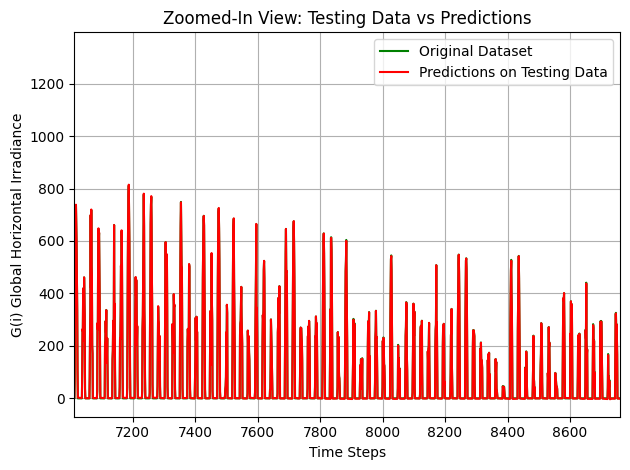

In [34]:
# Plot the original dataset
plt.plot(df_copy['G(i)'], 'g', label='Original Dataset')

# Plot the predictions
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')

# Add labels and legends
plt.xlabel('Time Steps')
plt.ylabel('G(i) Global Horizontal Irradiance')
plt.title('Zoomed-In View: Testing Data vs Predictions')
plt.legend()

# Zoom in on the testing data
test_start_index = look_back + len(inv_trainPredict) + (look_back*2) + 1
plt.xlim(test_start_index, len(df_copy['G(i)']))  # Focus on the first week

plt.grid()
plt.tight_layout()
plt.show()

# ARIMA Model

In [21]:
df_GI = df.iloc[:, [0]]

df_GI

,G(i)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8755,0.0
8756,0.0
8757,0.0
8758,0.0


   G(i)
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0


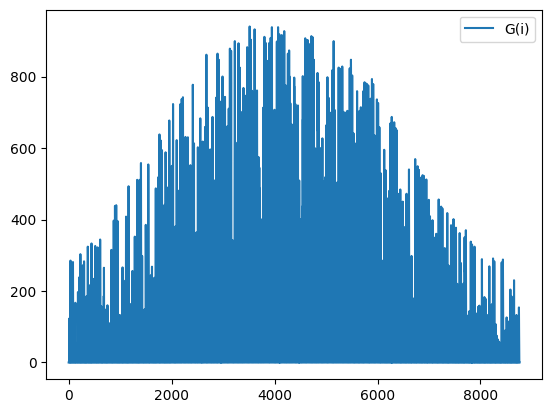

In [22]:
print(df_GI.head())

df_GI.plot()
plt.show()

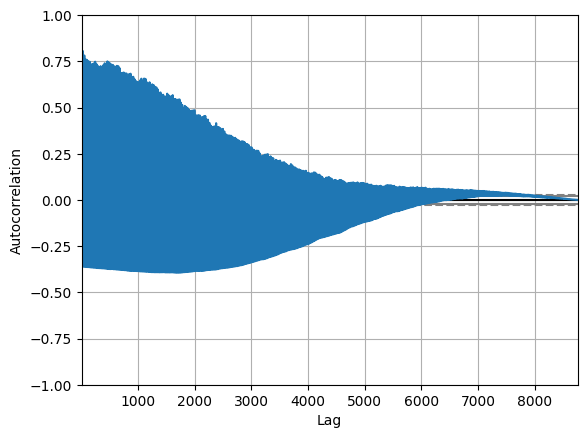

In [23]:
autocorrelation_plot(df_GI)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   G(i)   No. Observations:                 8760
Model:                ARIMA(50, 1, 0)   Log Likelihood              -49577.370
Date:                Thu, 16 Jan 2025   AIC                          99256.741
Time:                        16:42:39   BIC                          99617.711
Sample:                             0   HQIC                         99379.736
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2378      0.006    -42.372      0.000      -0.249      -0.227
ar.L2         -0.1733      0.006    -28.635      0.000      -0.185      -0.161
ar.L3         -0.1630      0.007    -23.693      0.0

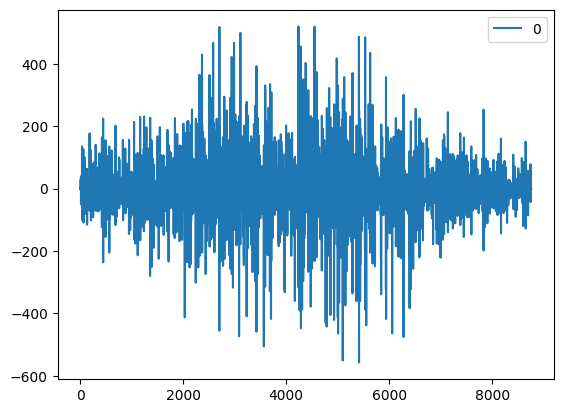

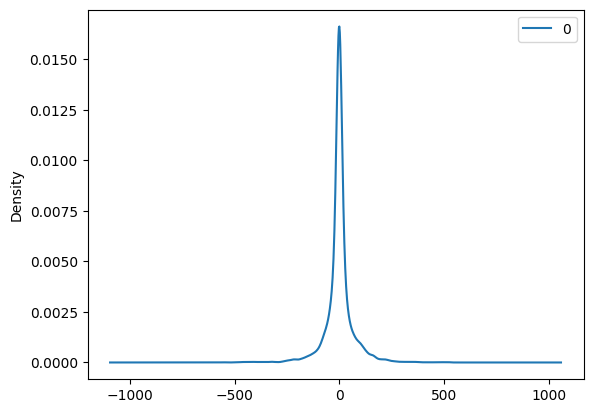

                 0
count  8760.000000
mean      0.008334
std      69.463870
min    -557.124367
25%     -14.908911
50%      -1.004432
75%      13.788319
max     519.785825


In [24]:
# fit model
model = ARIMA(df_GI, order=(50,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_29628\948908108.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=26.844017, expected=0.000000
predicted=-6.720848, expected=0.000000
predicted=8.356571, expected=0.000000
predicted=4.738060, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=37.000000
predicted=40.428142, expected=143.000000
predicted=164.570089, expected=294.010000
predicted=349.079482, expected=359.010000
predicted=415.845408, expected=409.010000
predicted=421.735845, expected=359.000000
predicted=316.744589, expected=317.000000
predicted=245.172025, expected=239.000000
predicted=167.593702, expected=160.000000
predicted=121.406945, expected=44.300000
predicted=10.208276, expected=0.000000
predicted=-22.580826, expected=0.000000
predicted=4.097261, expected=0.000000
predicted=39.327783, expected=0.000000
predicted=34.851443, expected=0.000000
predicted=27.777282, expected=0.000000
predicted=7.770241, expected=0.000000
predicted=0.257072, expected=0.000000
predi

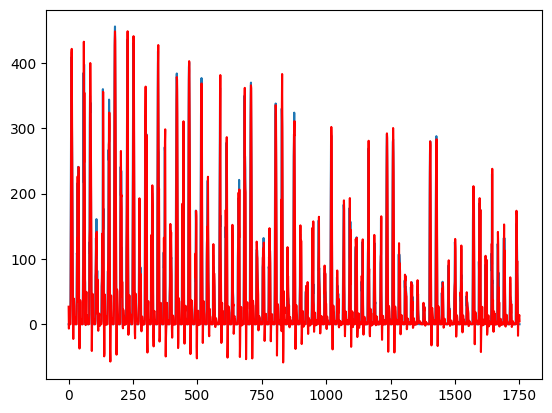

In [29]:
# split into train and test sets
X = df_GI.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

window_size = 100  # Use a fixed-size window for training
history = train[-window_size:]  # Start with the last 100 observations

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history = np.append(history, obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

NameError: name 'look_back' is not defined

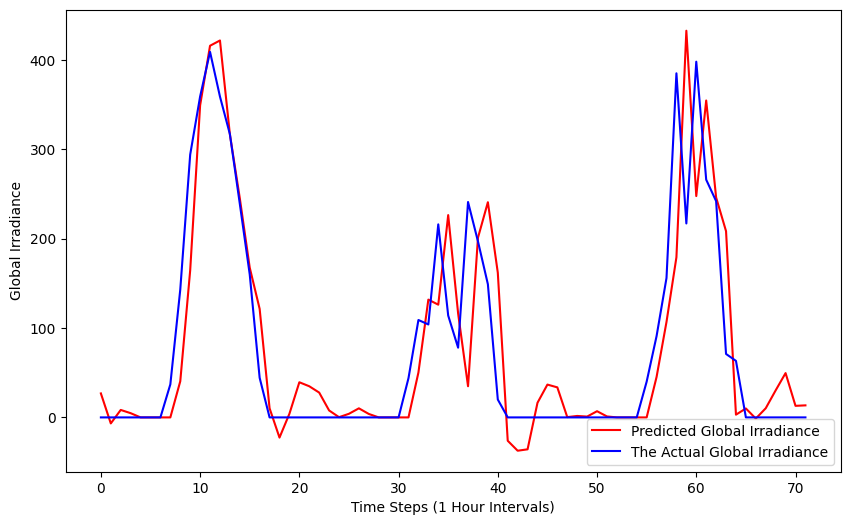

In [30]:
# Plotting the first 72 hours of predictions

plt.figure(figsize=(10, 6))
plt.plot(predictions[:72], 'r-', label='Predicted Global Irradiance')
plt.plot(test[:72], 'b', label='The Actual Global Irradiance')
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Irradiance')
plt.legend()
plt.title("Predicting the Global Irradiance of the first 72 hours with look_back = " + str(look_back))

In [31]:
arima_predictions = predictions
arima_test = test

np.savetxt(r"D:\Users\ugurhan\Desktop\LSTM Model\arima_test_values.txt", arima_test, fmt='%f')
np.savetxt(r"D:\Users\ugurhan\Desktop\LSTM Model\arima_prediction_values.txt", arima_predictions, fmt='%f')